Dodatkowe informacje: 
- proszę nie dodawać do spakowanego pliku ukrytych folderów takich jak `.git` oraz `__MACOSX`
- dodać plik `requirements.txt` z potrzebnymi bibliotekami do zainstalowania lub jeszcze lepiej `pyproject.toml` z wszystkimi wymaganiami projektu
- zamiast pisania `/` lub `\` w ścieżkach powinno użować się biblioteki `os`. Biblioteka rozpoznaje system na jakim się pracuje i sama uzupełnia ukośniki ponieważ na Windows są w drugą stronę niż w systemach Unix. Przykład użycia.: 
```
os.path.join("path1", "ptath2")
>>> path1/ptath2
```


In [1]:
#hide
import fastbook
fastbook.setup_book()

# Zadanie minimum

Wykorzystamy przykład z [fastbook](https://github.com/fastai/fastbook/blob/master/02_production.ipynb):

In [ ]:
# #hide 
# from fastbook import * 
# from fastai.vision.widgets import *

# lepiej importować jawnie funkcje ponieważ przez przypadek można nadpisać inne wbudowane funkcje pythona
from fastai.vision.all import (
    ImageBlock,
    CategoryBlock, 
    get_image_files, 
    RandomSplitter, 
    Resize, 
    RandomResizedCrop, 
    aug_transforms, 
    vision_learner, 
    resnet18, 
    error_rate,
    ClassificationInterpretation,
    load_learner,
    PILImage,
    )

from fastbook import DataBlock, parent_label

from ipywidgets import widgets, VBox
from types import SimpleNamespace


In [ ]:
from pathlib import Path # nie było zaimportowane

path = Path('loko')

In [12]:
loko = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
    )

In [13]:
#hide
dls = loko.dataloaders(path)

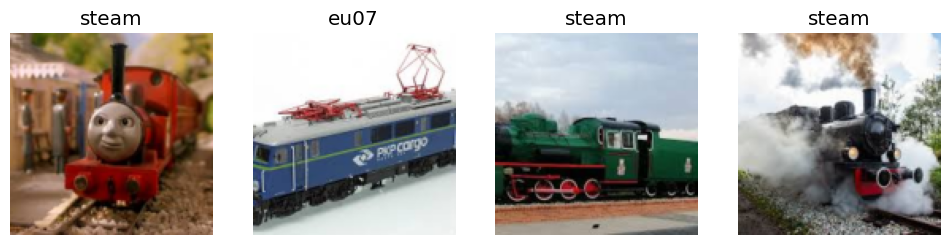

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

### Przygotowanie danych

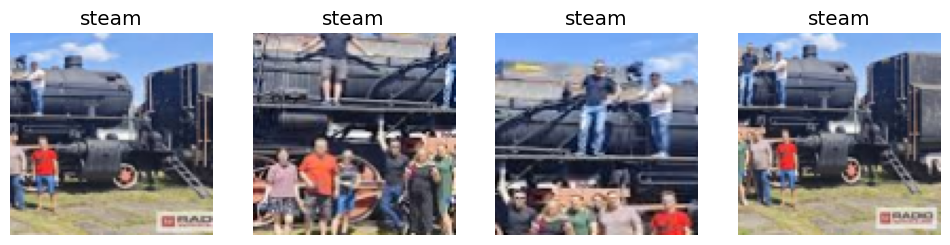

In [15]:
loko = loko.new(item_tfms=RandomResizedCrop(96, min_scale=0.1))
dls = loko.dataloaders(path, bs=20)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

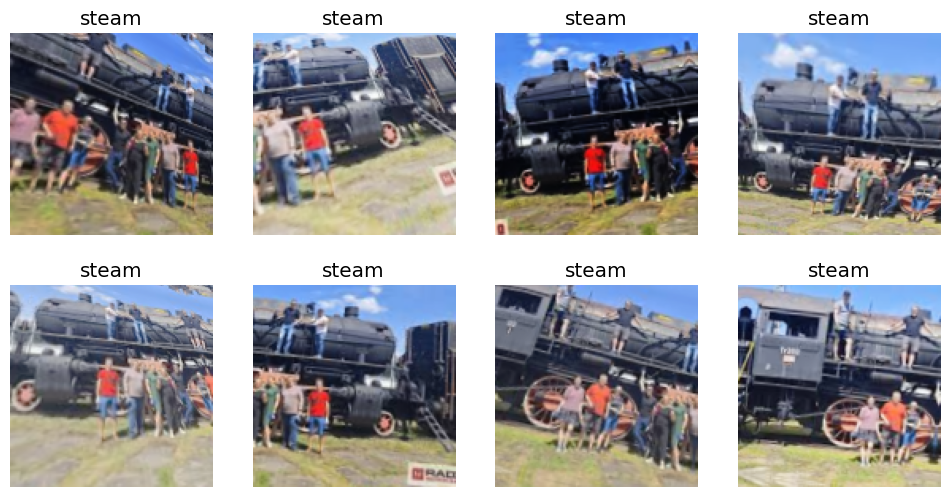

In [16]:
#hide
loko = loko.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=1.5))
dls = loko.dataloaders(path, bs=25)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Trenowanie

Wykorzystamy istniejący model [rosnet18](https://fastai1.fast.ai/vision.models.html).

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5) # można poeksperymentować

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/marceli/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 13.7MB/s]


epoch     train_loss  valid_loss  error_rate  time    
0         1.567305    1.731310    0.375000    00:01                                    
epoch     train_loss  valid_loss  error_rate  time    
0         1.480398    1.236843    0.312500    00:00                                    
1         1.384688    1.237885    0.437500    00:00                                    
2         1.315409    1.348485    0.437500    00:00                                    
3         1.205360    1.463392    0.375000    00:00                                    
4         1.108255    1.349398    0.375000    00:00                                    


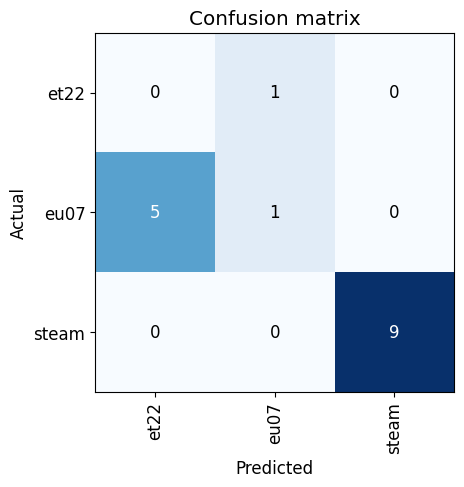

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

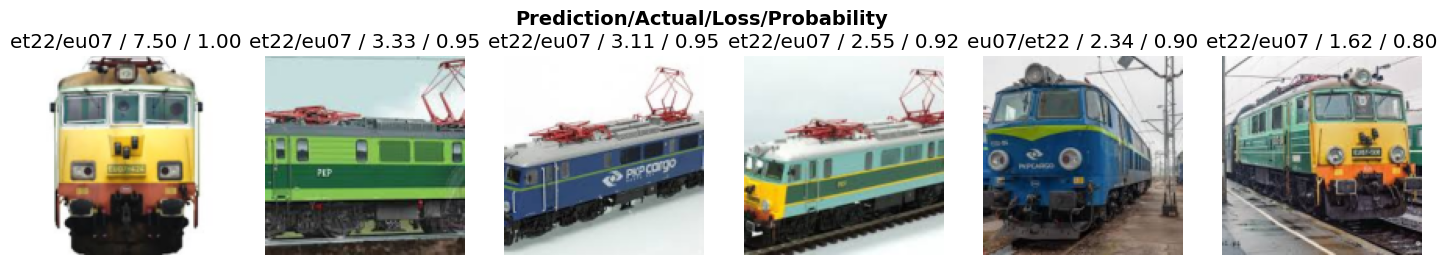

In [19]:
interp.plot_top_losses(6, nrows=1)

In [20]:
learn.export() # Eksport przetrenowanego modelu (może się przydać przy użytku w innym projekcie)

In [ ]:
path = Path()
learn_inf = load_learner(path/'export.pkl') # import zapisanego wyżej modelu (tak dla zasady)

In [31]:
# Inicjalizacja widgetów
out_pl = widgets.Output()
out_pl.clear_output()
btn_upload = SimpleNamespace(data = ['loko/steam/images-10.jpeg'])

# Używamy PILImage z fastai do utworzenia obrazu
img = PILImage.create(btn_upload.data[-1])

with out_pl:
    display(img.to_thumb(256, 256))

btn_run = widgets.Button(description='Classify')
lbl_pred = widgets.Label()
lbl_pred.value = ""

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

def on_upload_change(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl:
        display(img.to_thumb(256, 256))

btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()
btn_upload.observe(on_upload_change, names='_counter')
VBox([widgets.Label("Let's find out how it works!"), btn_upload, btn_run, out_pl, lbl_pred])
